# Mod 4 Online Project 

## Introduction

For this project, I am acting as a consultant for a fictional real-estate investment firm. The firm has asked us what seems like a simple question:

> What are the top 5 best zipcodes for us to invest in?

We will have to access the housing data, and run some time series analysis on it to make predictions on the prices of future houses. Then, depending on our definition of "best zipcodes", we will be able to make our recommendation.

## Our definition of "Best"

There are so many way we could define "best" when it comes to what zipcodes we should invest our money into. What houses could bring us the maximum gross return on our investment? What about percentage rise? What about if we are trying to be careful so that our investment is least likely to lose money? What time scale should we be looking at (5/10/20 years)? All of them are sensible approaches, but this is the one I am going for:

`"The highest percentage rise in house price after 5 years, with a 95% assurance that our house price won't drop more than 10% in the first two years"`

More specifically, we will take a time point after 5 years from where our data ends, and calculate the expected percentage rise in value. Whichever zip code is highest wins, on the assumption that the 95% confidence interval lower bound for the price isn't lower than the starting price minus 10%. 

We could absolutely make this definition more sophisticated - by taking some mean value of price over year 5 instead, or perhaps by incorporating some sort of selection criteria to do with budget (we might only have $200k to spend). For now, this will do, just so that we can stretch our time series modelling legs.

# Importing the Data 

## Importing the appropriate libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Importing and manipulating the data

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.drop(['RegionID','SizeRank'],axis=1,inplace=True)
#dropping some pointless columns

In [5]:
df.shape

(14723, 270)

So, looks like we have 265 months of the mean prices in 14723 neighbourhoods - this is massive!

Now to transform it into a workable format for our modelling 

In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    return melted

#this function will reshape our dataframe from "wide format" to "long format"
#it does this by using the melt() function in pandas, 
#which creates new rows of data for every column not listed as an id_vars
#it then sets our time column to a datetime object for further fuctionality 

In [7]:
long_df=melt_data(df)
long_df.head()

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [8]:
sorted_long_df = long_df.sort_values(['RegionName','time'])
#we sort our data so that we have a chronological dataframe split up by neighbourhood
#ie the first 265 rows are neighbourhood 1001, the next 265 rows are neighbourhood 1002 etc

In [9]:
sorted_long_df

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0
...,...,...,...,...,...,...,...
3835273,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2017-12-01,291900.0
3849996,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-01-01,294200.0
3864719,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-02-01,297500.0
3879442,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-03-01,302100.0


This dataframe is way too big to work with, so lets take a small section of it! 

Let's model the neighbourhoods of Boston, MA

In [10]:
df_boston = sorted_long_df[(sorted_long_df['State'] == 'MA') & (sorted_long_df['City'] == 'Boston')]
len(df_boston)

4770

In [11]:
df_boston.head()

,RegionName,City,State,Metro,CountyName,time,value
12041,2110,Boston,MA,Boston,Suffolk,1996-04-01,135400.0
26764,2110,Boston,MA,Boston,Suffolk,1996-05-01,137500.0
41487,2110,Boston,MA,Boston,Suffolk,1996-06-01,139600.0
56210,2110,Boston,MA,Boston,Suffolk,1996-07-01,141800.0
70933,2110,Boston,MA,Boston,Suffolk,1996-08-01,143900.0


In [12]:
print(df_boston.RegionName.value_counts().max(),sorted_long_df.RegionName.value_counts().min())
#checking that we have 265 data points for each neighbourhood 

265 265


If the maximum and minimum number of data points we have for each neighbourhood is 265, then we certainly have 265 for each!

In [13]:
df_boston.isna().sum()

RegionName      0
City            0
State           0
Metro           0
CountyName      0
time            0
value         219
dtype: int64

So, it's worth noting that some of the values for house prices are missing! We will need to fill these in if we are going to model those neighbourhoods

If we encountered a neighbourhood with lots of missing values, then we would remove it entirely, but if there are only a few missing values, then we could use the bfill() function to fill in those gaps by just copying in what came directly before the gap.

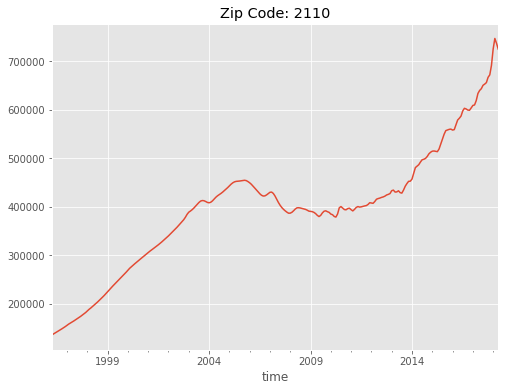

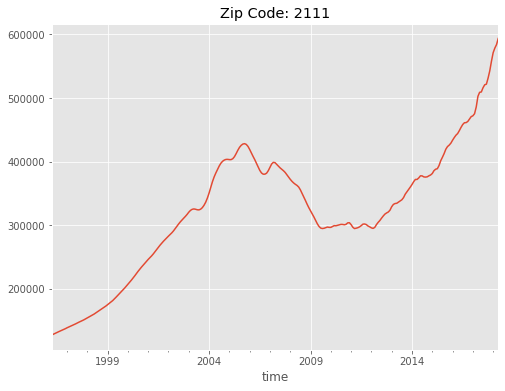

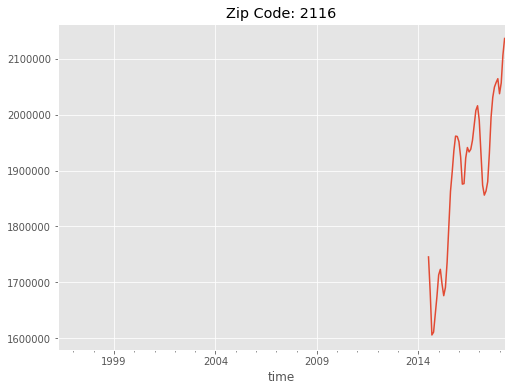

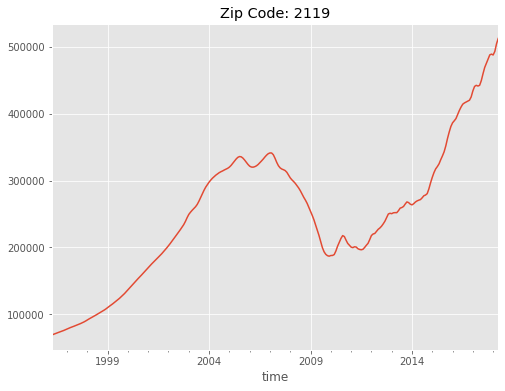

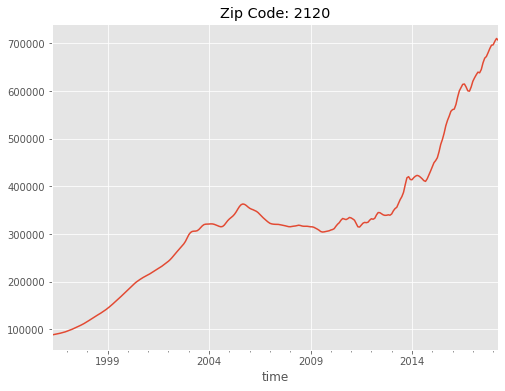

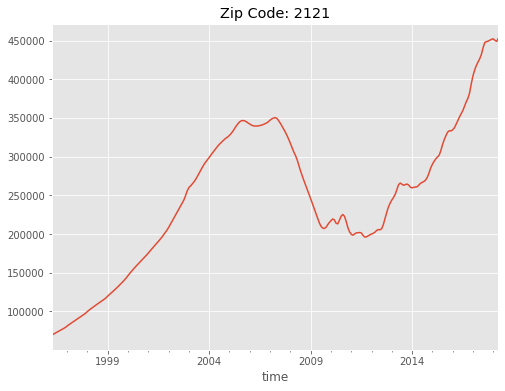

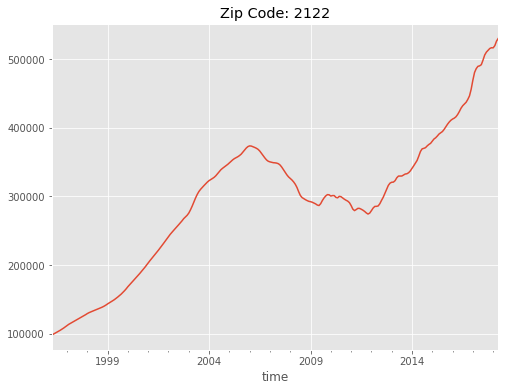

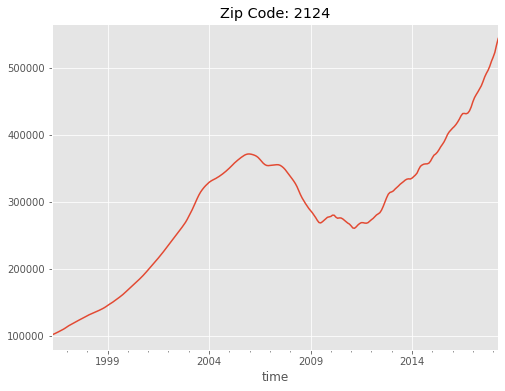

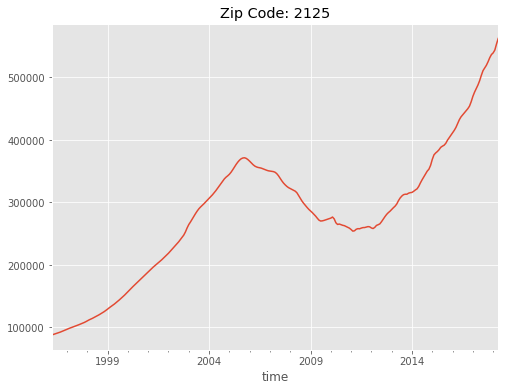

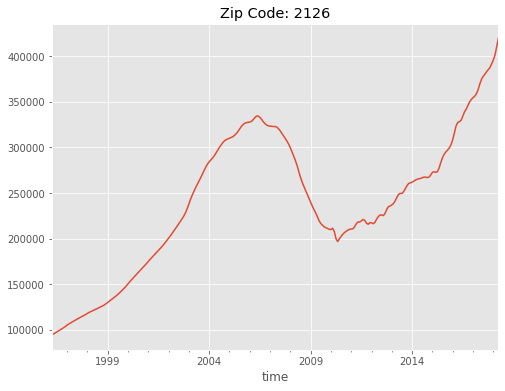

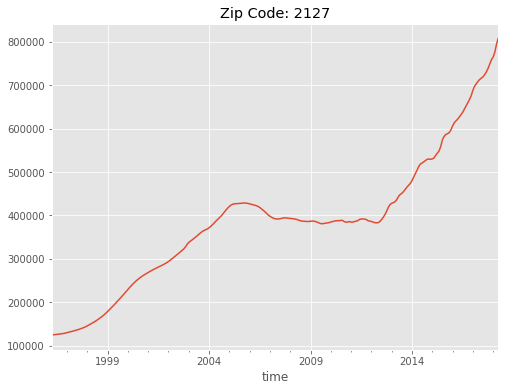

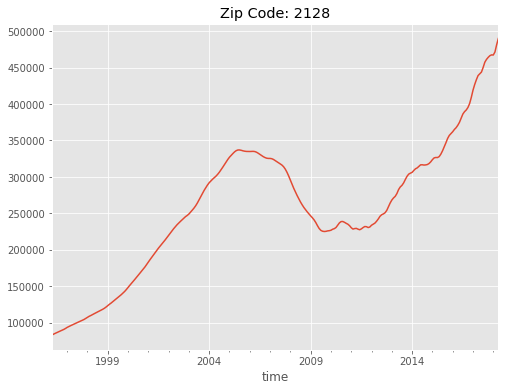

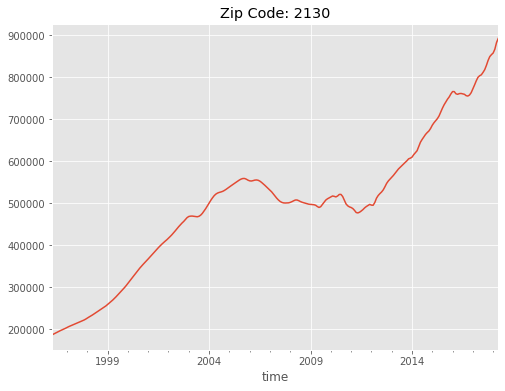

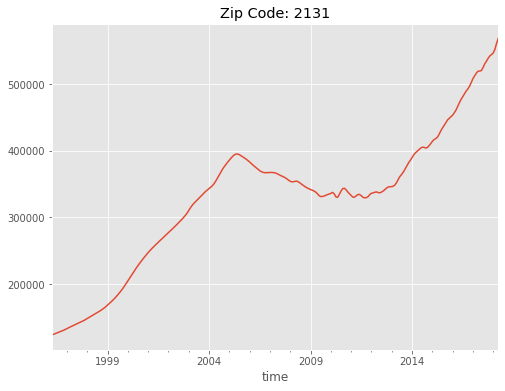

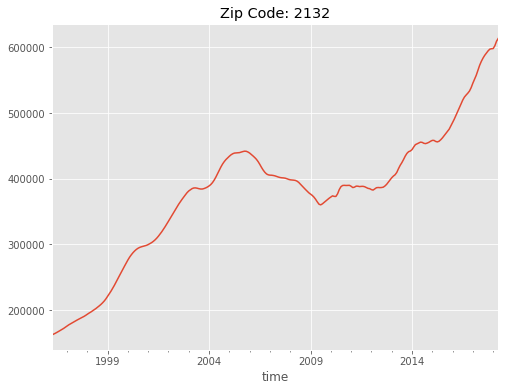

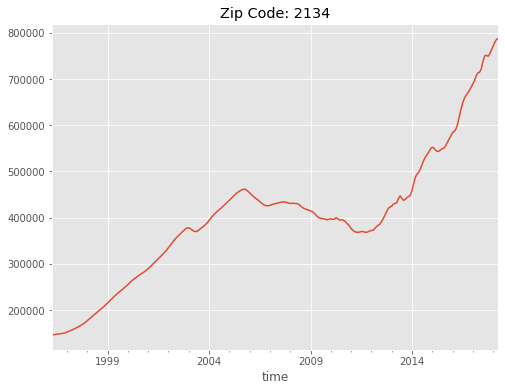

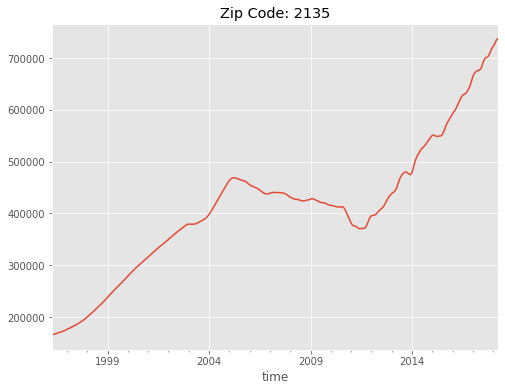

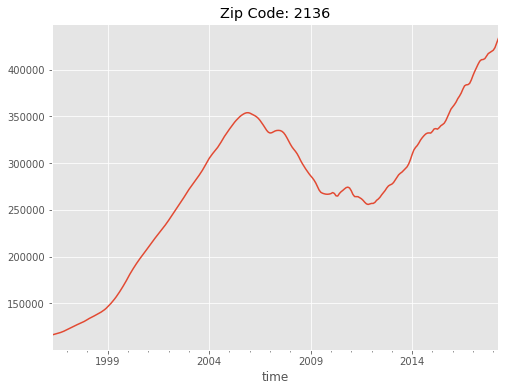

In [14]:
for zipcode in df_boston.RegionName.unique():
    df_now = df_boston[df_boston['RegionName'] == zipcode]
    df_now.set_index('time')['value'].plot(kind = 'line', figsize=(8,6))
    plt.title("Zip Code: {}".format(zipcode))
    plt.show()

Looks like its just Zipcode 2116 that's missing all the values! Way too many values missing to back fill, so lets just remove it entirely

In [16]:
df_boston = df_boston[df_boston['RegionName'] != 2116]

In [17]:
df_boston.isna().sum()

RegionName    0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64

Now we have a clean dataset we can run models on!


# Running a SARIMA model on our data

This next box of code is the result of lots of trial and error - it works following these steps:

1 - Creating all the possible combinations of 0,1 and 2 that we could use as parameters in the ARIMA modelling algorithm

2 - Models each Neighbourhood with every combination of parameters, and choses the best model by taking the lowest AIC

3 - Using each best model, it forcasts 5 years into the future

4 - It stores each Neighbourhoods expected price in 5 years, as long as after 2 years the lower bound on price hasn't dropped below the last known price. 

5 - It ranks each stored Neighbourhood by percentage increase of price after 5 years, and returns the top 5!

In [ ]:
record = {}

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

count = 0

for x in range(0,17):
    count += 1
    df = df_boston[x*265:(x+1)*265]
    df.set_index('time',inplace=True)
    region = df.loc['1997-04-01','RegionName']
    df = df.drop(['RegionName','City','State','Metro','CountyName'],axis=1)
    #we prepare each neighbourhood to be run thorough our model one by one

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    #We have run every possible permutation of the parameters of our model
    
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    #We store all the results, and find the set of parameters which gives us the lowest AIC, ie the most accurate model

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                            seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
                                             

    output = ARIMA_MODEL.fit()
    #We then run this model again with these best parameters, allowing us to make the prediction 

    prediction = output.get_forecast(steps=60)
    #we predict the values for 60 months ahead of our last value
    
    pred_conf = prediction.conf_int(alpha = .05)
    #we calculate the confidence intervals of our predictions
    
    print(((prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100), count)
    
    if (pred_conf.iloc[23, 0] > df['value'][-1]*.9):
        #checking that we can be sure that house prices are unlikely to drop more than 10% in two years
    
        record.update({region : (((prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100), count)})
        #we record the final value in the 60th month, as a percentage increase from the last value we were given
    
    
    sorted_record = sorted(record.items(), key=lambda x: x[1], reverse=True)
    #we sort the values in order of highest increase
    
print(sorted_record[:5])
#we print out the best 5 neighbourhoods!

# Visualisations and Results 

## Visualisations

Let's have a closer look at those top 5 and see how the projections looks, as well as check them for stationarity!

In [19]:
df_boston_copy = df_boston

df_2111 = df_boston_copy[(265*1):(265*2)]
df_2124 = df_boston_copy[(265*6):(265*7)]
df_2127 = df_boston_copy[(265*9):(265*10)]
df_2119 = df_boston_copy[(265*2):(265*3)]
df_2126 = df_boston_copy[(265*8):(265*9)]

#first we make the 5 dataframes of the neighbourhoods we suspect of being the best

Similar to chapter 3, we will find the best Model for each Neighbourhood, but then instead of storing the results, we will simply plot them to have a closer look!

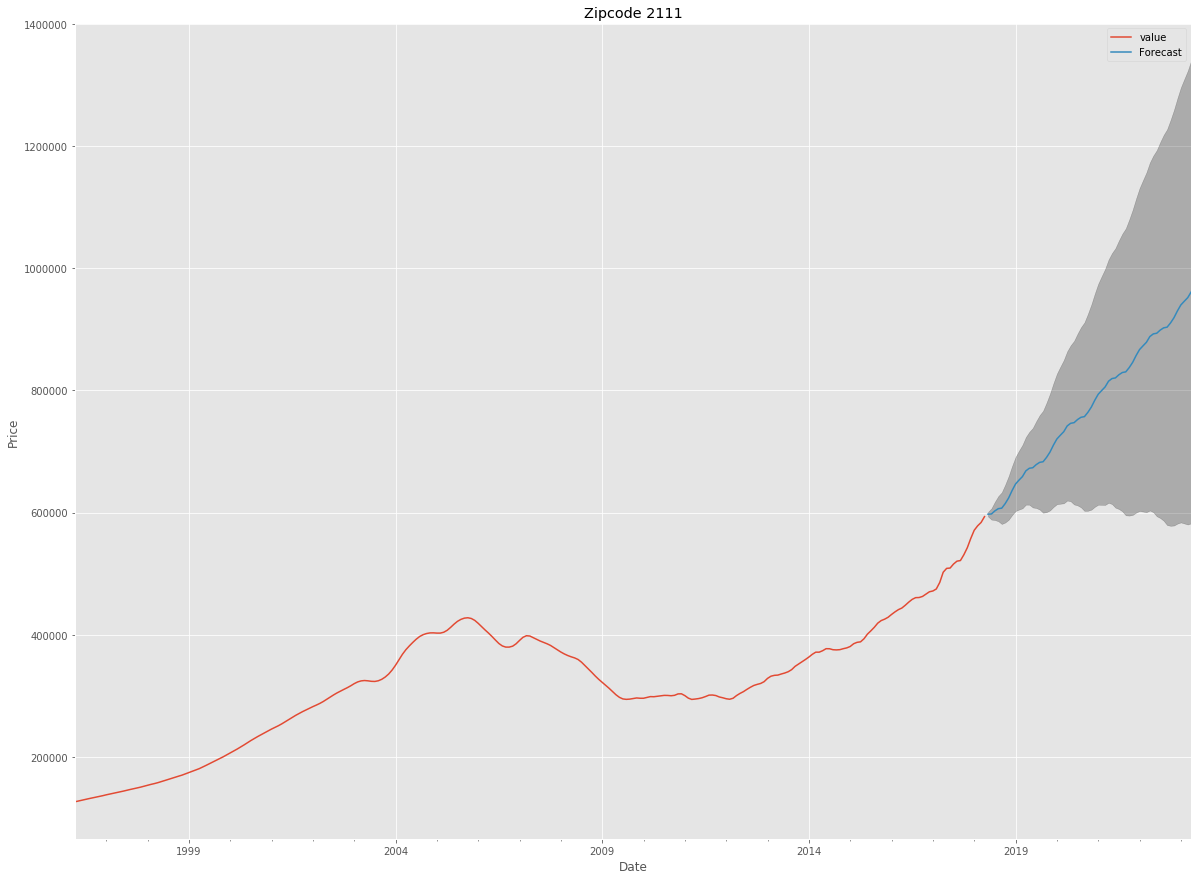

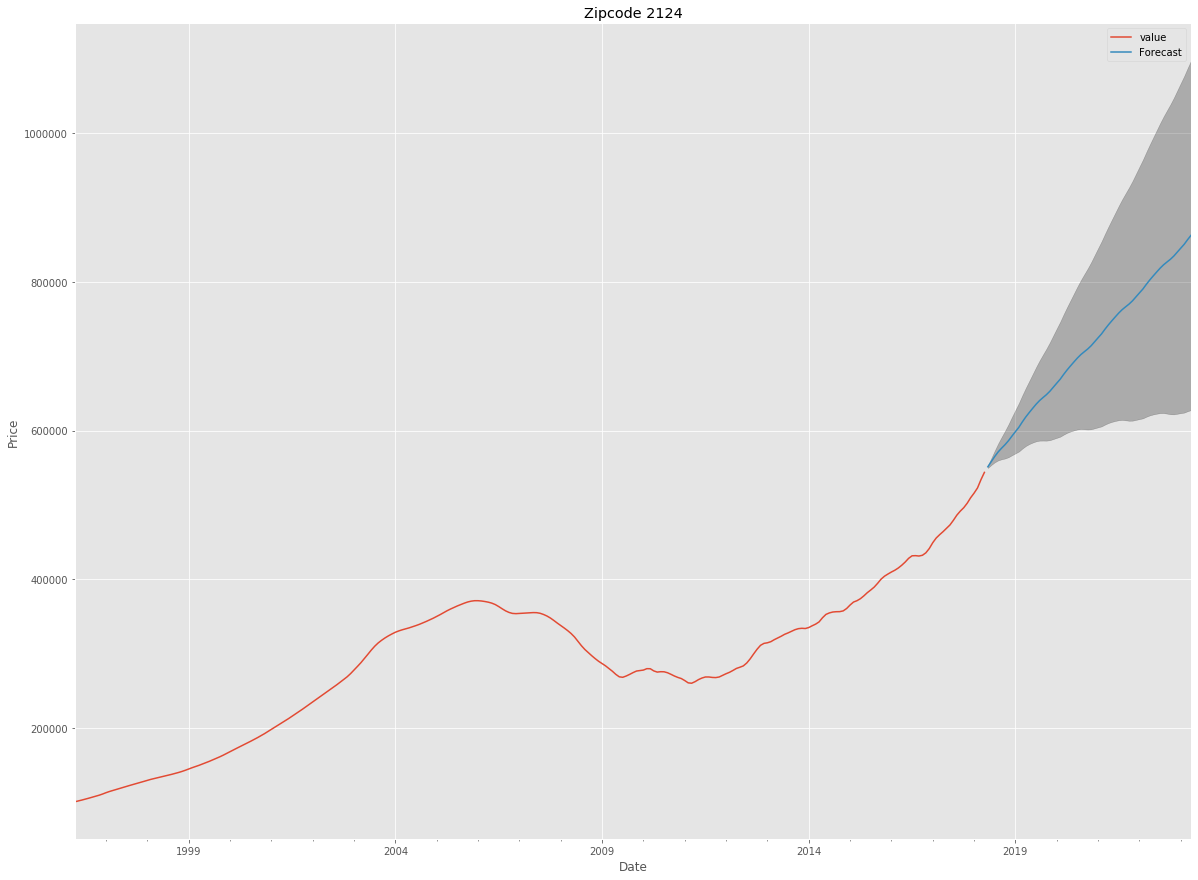

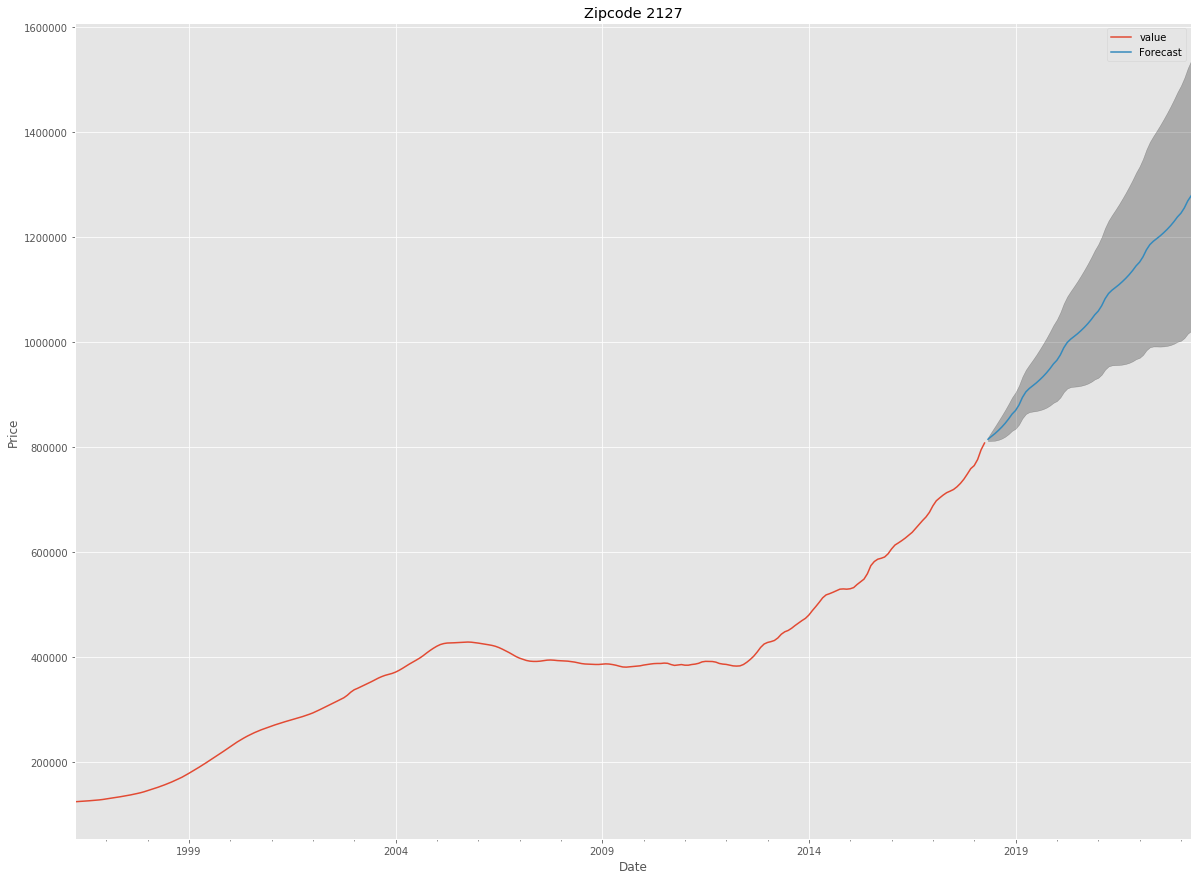

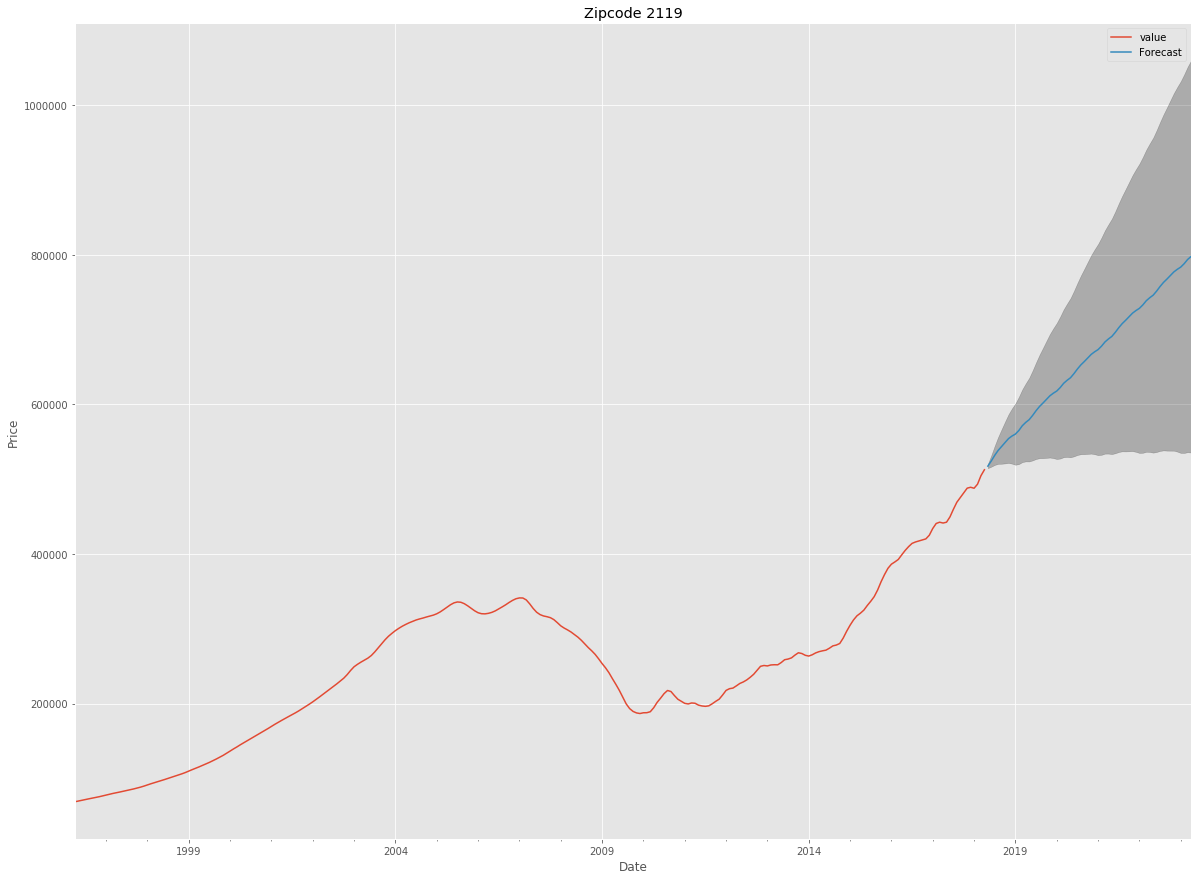

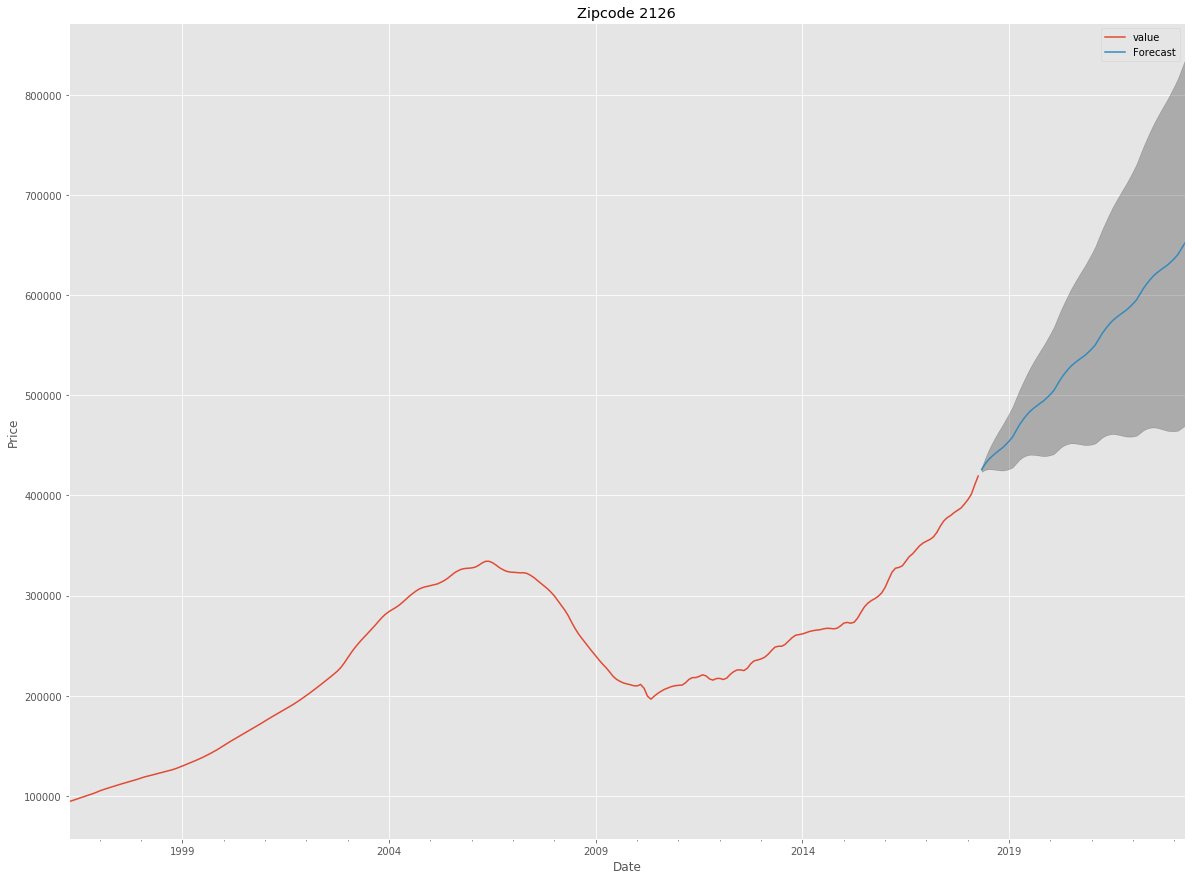

In [74]:
results = pd.DataFrame()
results['Region'] = []
results['Final_known_price'] = []
results['5_year_expected_price'] = []
results['5_year_lower_bound_price'] = []
results['5_year_upper_bound_price'] = []
results['5_year_expected_pc_increase'] = []

for df in [df_2111, df_2124, df_2127, df_2119, df_2126]:
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    

    df.set_index('time',inplace=True)
    region = df.loc['1997-04-01','RegionName']
    last_price = df.loc['2018-04-01','value']
    df.drop(['RegionName','City','State','Metro','CountyName'],axis=1,inplace = True)

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                            seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    #Now we take our best neighbourhood and run it through again to model is as well as we can 

    pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False, full_results=True)
    pred_conf = pred.conf_int()

    # Get forecast 60 steps ahead in future
    prediction = output.get_forecast(steps=60)

    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    

    # Plot future predictions with confidence intervals
    ax = df.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Zipcode {}'.format(region))
    
    plt.legend()
    plt.show()
    

    #append results to the results dataframe
    results = results.append({'Region': region, \
                              'Final_known_price': last_price, \
                              '5_year_expected_price': prediction.predicted_mean[59], \
                              '5_year_lower_bound_price': pred_conf.iloc[59, 0], \
                              '5_year_upper_bound_price': pred_conf.iloc[59, 1], \
                              '5_year_expected_pc_increase': (prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100}, \
                              ignore_index=True)

## Results

In [76]:
for x in results.columns:
    results[x] = results[x].astype(int)
#this is just to make the results more readable

results

,Region,Final_known_price,5_year_expected_price,5_year_lower_bound_price,5_year_upper_bound_price,5_year_expected_pc_increase
0,2111,593600,961249,582642,1339856,61
1,2124,543900,862863,627755,1097971,58
2,2127,807900,1278992,1021348,1536636,58
3,2119,512600,797617,535603,1059631,55
4,2126,419400,651901,469589,834213,55


Great! We have our top 5 neighbourhood. But have a closer look at the lower bounds and upper bounds for 5_year_price. the first neighbourhood, while expected to return 3% more over 5 years, has much wider confidence intervals. Perhaps we should consider the other neighbourhoods as better, because their small confidence intervals suggests more likely returns, even if slightly smaller!

## Final Check of Best Neighbourhood's model's performance

By looking at the confidence intervals, we can see how confident the model is at it's own accuracy. 

Although the 'best' zipcode to invest in in our original definition is 2111, perhaps more weary investors ought to invest in the third best zipcode, as it's confidence intervals are much narrower! The lower bound for the third neighbourhood's price in 5 years is still 25% more than the 'current' price! 

We can be quite sure that after 5 years, 2127 will be making good returns. 

Let's look to see how closely that third model is fitting to the data

In [21]:
df_2127_copy = df_boston_copy[(265*9):(265*10)]

In [22]:
df_2127_copy.head()

,RegionName,City,State,Metro,CountyName,time,value
1511,2127,Boston,MA,Boston,Suffolk,1996-04-01,124600.0
16234,2127,Boston,MA,Boston,Suffolk,1996-05-01,125000.0
30957,2127,Boston,MA,Boston,Suffolk,1996-06-01,125500.0
45680,2127,Boston,MA,Boston,Suffolk,1996-07-01,125900.0
60403,2127,Boston,MA,Boston,Suffolk,1996-08-01,126400.0


In [23]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


df_2127_copy.set_index('time',inplace=True)
region = df_2127_copy.loc['1997-04-01','RegionName']
df_2127_copy.drop(['RegionName','City','State','Metro','CountyName'],axis=1,inplace = True)

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_2127_copy,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA_MODEL_2127 = sm.tsa.statespace.SARIMAX(df_2127_copy, 
                                        order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                        seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

In [24]:
output_2127 = ARIMA_MODEL_2127.fit()
print(output_2127.summary().tables[1])
print(output_2127.aic)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5823      0.042     14.012      0.000       0.501       0.664
ma.L1          0.6304      0.037     17.175      0.000       0.558       0.702
ar.S.L12       0.2100      0.079      2.644      0.008       0.054       0.366
ma.S.L12      -0.5078      0.071     -7.125      0.000      -0.647      -0.368
sigma2      3.262e+06      2e+05     16.332      0.000    2.87e+06    3.65e+06
4225.294369563189


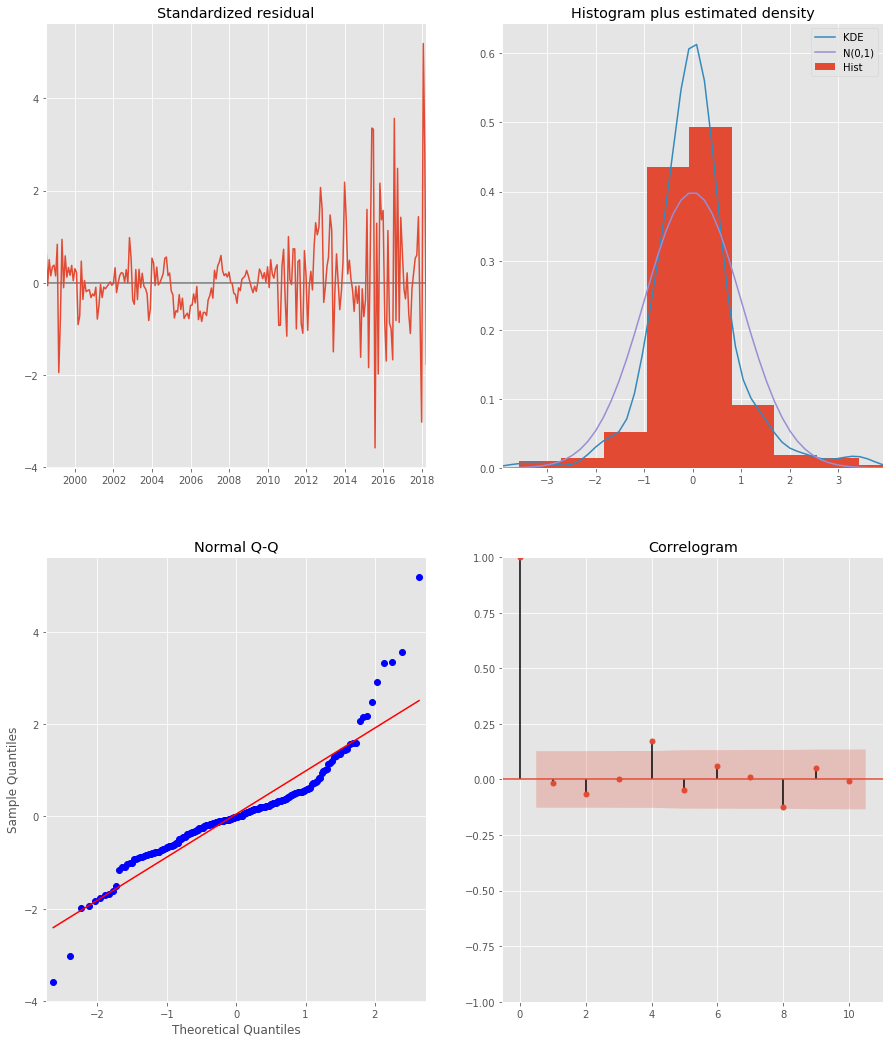

In [25]:
output_2127.plot_diagnostics(figsize=(15, 18))
plt.show()

The outputs aren't great but not awful...!

In [39]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_conf = pred.conf_int()

In [40]:
# Get the real and predicted values
df_2127_forecasted = pred.predicted_mean
df_2127_truth = df_2127_copy['1996-04-01':]

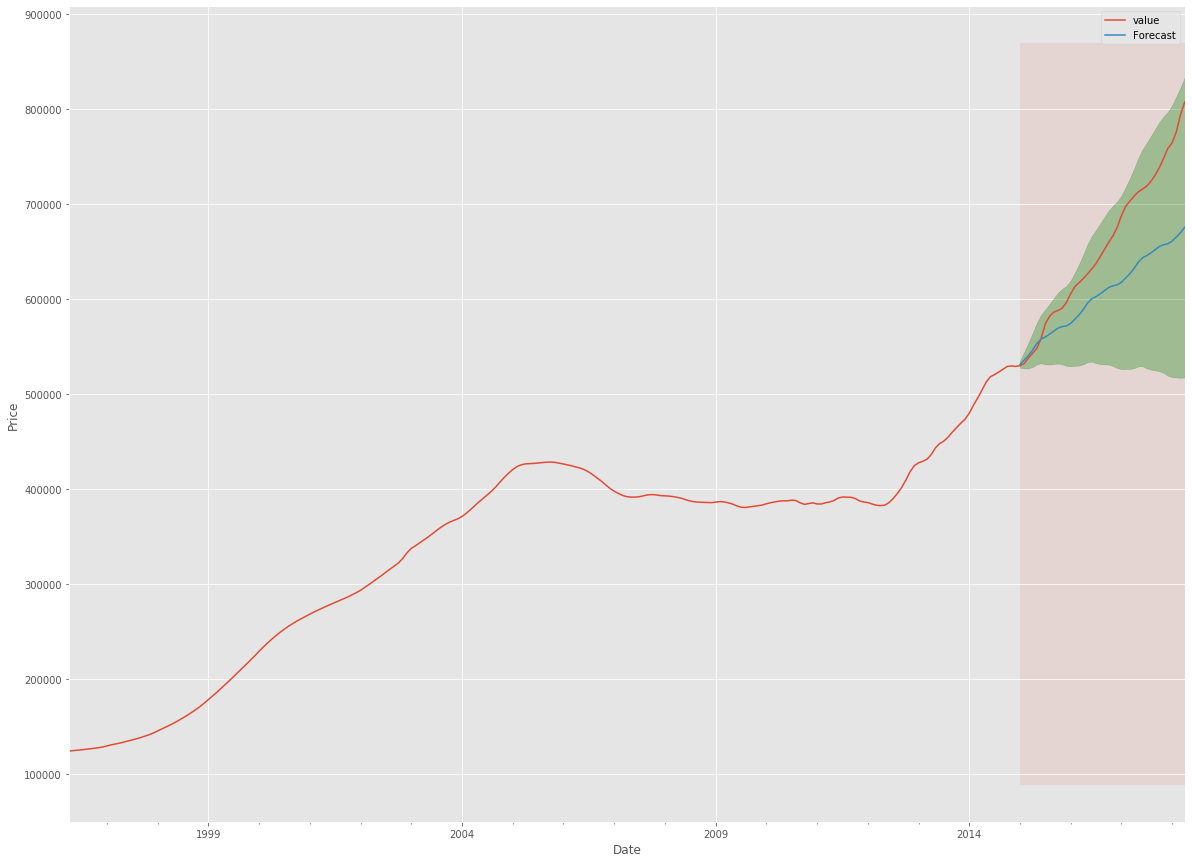

In [41]:
# Plot the dynamic forecast with confidence intervals.

ax = df_2127_copy['1996':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(label='Forecast', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), df_2127_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

With dynamic forcasting, the model is less of a close fit, but this is to be expected as we aren't using all the avaliable data! Luckily, it isn't too far off to call this model a particularly bad one, clearly still within the reasonable confidence intervals!

# Conclusion

This project has been a great bit of practice trying to predict things in the future using time series modelling.

We found the top 5 neighbourhoods in terms of suspected return of value, but ultimately my final recommendation would be neighbourhood 2127 for all but the most risky investors, because of its safe confidence intervals.